# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
from pathlib import Path
from PIL import Image as Image_PIL
import imghdr # built in module
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import gdown  # Google Drive 

In [3]:
!which python

/Users/maurice/anaconda3/envs/fastai/bin/python


# Paths

In [7]:
data_path = Path.home() / 'CloudStation/data_science/01-python_lab/99_datasets/mushrooms'
data_path_other = Path('../data')
test_train_path = data_path / 'test_and_train'
train_folder = test_train_path / 'train'
test_folder = test_train_path / 'test'
google_path = data_path / 'google'

## Load the dictionary

In [8]:
dict_mushrooms_path = data_path_other / 'dict_mushrooms.json'

In [9]:
with open(dict_mushrooms_path, 'r') as fp:
    dict_mushrooms = json.load(fp)

# Download images (Google)

To download the images from a Google search, pres <Ctl+Alt+J> and the Web Console window will appear. Type the following command:
 
    urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
    window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
    
This will open a dialog box asking to save the file. Save it with the name of the mushroom.

**Note**: I used the latin name in order to filter the search.


In [40]:
csv_folder = google_path / 'csv'

In [41]:
for csv_file in csv_folder.iterdir():
    print(f'Processing {csv_file.name} file...')
    folder_name = train_folder / csv_file.stem
    if not folder_name.is_dir() and (csv_file.suffix == '.csv'):
        print(f'Creating folder {folder_name}...')
        os.mkdir(folder_name)
    if csv_file.suffix == '.csv':
        print(f'Downloading {csv_file.stem} images...')
        download_images(csv_file, folder_name)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/google/csv'

# Train the model

## Create `labels.csv` file

In [10]:
dict_mushrooms_path = data_path_other / 'dict_muchrooms.json'

In [11]:
def is_image(file, valid_img_types=['jpeg', 'png', 'tiff', 'bmp']):
    """"""
    img_type = imghdr.what(file)
    if (img_type not in valid_img_types) or (img_type is None):
        if img_type is None:
            try:
                # import pdb; pdb.set_trace()
                im=Image_PIL.open(file)
                return True
            except IOError:
                return False
        elif img_type not in valid_img_types:
            return False
    else:
        return True

In [12]:
unknown_folder = test_train_path / '_unknown'
unknown_folder

PosixPath('/Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/_unknown')

In [13]:
df_labels = pd.DataFrame(columns=['name', 'labels'])

for mushroom in train_folder.iterdir():
    try:
        mushroom_ = mushroom.stem
        print(f'- processing folder {mushroom}')
        i = 0  # Initialize image count
        j = 0  # Initialize bad image count
        for image in mushroom.iterdir():
            if is_image(image):
                # rename image:
                new_name = f'{mushroom_}_{str(i).zfill(4)}.jpg'
                # Prevent overwriting previously downloaded images with same target name
                while (train_folder / mushroom_ / new_name).exists():
                    # import pdb; pdb.set_trace()
                    i +=1
                    new_name = f'{mushroom_}_{str(i).zfill(4)}.jpg'
                os.rename(str(image), str(train_folder / mushroom_ / new_name ))
                image = image.with_name(new_name)
                dict_img = {
                    'name': Path(mushroom_) / image.name,
                    'labels': f'{dict_mushrooms[mushroom_]["name"]} ({dict_mushrooms[mushroom_]["latin"]}): ' +\
                            f'{dict_mushrooms[mushroom_]["edibility"]}',  
                }
                df_labels = df_labels.append(dict_img, ignore_index=True)
                i += 1
            elif is_image(image) is False:
                suffix = image.suffix
                if image.suffix in ['mp4', 'gif', '.webp', '.ashx', '.webp']:
                    print(f'Removing not an image file: {image}')
                    #import pdb; pdb.set_trace()
                    os.remove(image)
                    #os.rename(str(image), str( unknown_folder / new_name ))
                else:
                    new_name = f'{mushroom_}_{str(j).zfill(4)}.{suffix}'
                    j += 1
                    print(f'Renaming corrupt image {image}')
                    os.rename(str(image), str( unknown_folder / new_name ))   
    except NotADirectoryError as e:
        import pdb; pdb.set_trace()
        if  '.DS_Store' in str(mushroom):
            print(f'Removing .DS_Store file...')
            #import pdb; pdb.set_trace()
            os.remove(mushroom)
        else:
            print(e)


- processing folder /Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/train/Lycoperdon_perlatum
- processing folder /Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/train/Lactarius_deliciosus
- processing folder /Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/train/Calocybe_gambosa
Renaming corrupt image /Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/train/Calocybe_gambosa/.DS_Store
- processing folder /Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/train/Rubroboletus_satanas
- processing folder /Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/train/Hygrophorus_latitabundus
Renaming corrupt image /Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/train/Hygrophorus_latitabundus/.DS_Store
- 

In [14]:
df_labels.to_csv(data_path_other / 'labels.csv', index=False)

## generate databunch

Add some data augmentation with `get_transforms`:

In [16]:
tfms = get_transforms(
    flip_vert=True,
    max_lighting=0.1,
    max_zoom=1.05,
    max_warp=0.5
)

Define batch size, image size:

In [25]:
bs = 32 # 64       # batch_size
size = 128
np.random.seed(42) # set random seed so we always get the same validation set

Create an `ImageDataBunch` from `path` by splitting the data in folder and labelled in a file `csv_labels` between a training and validation set.

Use `valid_pct` to indicate the percentage of the total images to use as the validation set. An optional test folder contains unlabelled data and suffix contains an optional suffix to add to the filenames in `csv_labels` (such as '.jpg').
* `fn_col` is the index (or the name) of the the column containing the filenames and 
* `label_col` is the index (indices) (or the name(s)) of the column(s) containing the labels.
* Use `header` to specify the format of the csv header, and
* `delimiter` to specify a non-standard csv-field separator.

In case your csv has no header, column parameters can only be specified as indices. If `label_delim` is passed, split what's in the label column according to that separator.

In [27]:
test_train_path

PosixPath('/Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train')

doc(ImageDataBunch)

In [28]:
img_data = ImageDataBunch.from_folder(
    #path=test_train_path,
    path=train_folder,
    #train='train',
    valid_pct=0.2,  
#    valid='test',
    ds_tfms=get_transforms(),
    size=size,
    bs=bs,
#    seed=seed
)

In [29]:
img_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (6444 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Lycoperdon_perlatum,Lycoperdon_perlatum,Lycoperdon_perlatum,Lycoperdon_perlatum,Lycoperdon_perlatum
Path: /Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/train;

Valid: LabelList (1611 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Laetiporus_sulphureus,Melanoleuca_excissa,Macrolepiota_procera,Cantharellus_lutescens,Hebeloma_laterinum
Path: /Users/maurice/CloudStation/data_science/01-python_lab/99_datasets/mushrooms/test_and_train/train;

Test: None

First image of the training dataset:

In [31]:
img_data.train_ds[0]

(Image (3, 128, 128), Category Lycoperdon_perlatum)

First image of the validation dataset:

In [34]:
img_data.valid_ds[0]

(Image (3, 128, 128), Category Laetiporus_sulphureus)

Show some images from the dataset:

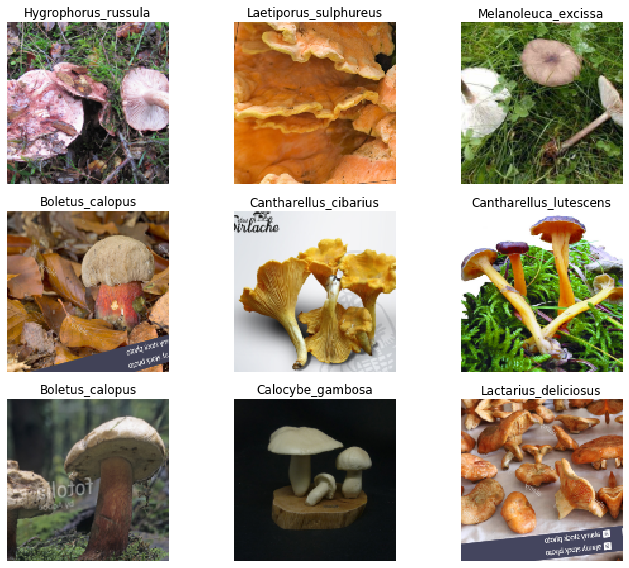

In [35]:
img_data.show_batch(rows=3, figsize=(10,8))

Number of classes in the dataset

In [47]:
# Number of categories
img_data.c

24

In [36]:
# Names of the categories
img_data.classes

['Amanita_caesarea',
 'Amanita_muscaria',
 'Amanita_pahlloides',
 'Boletus_calopus',
 'Boletus_edulis',
 'Calocybe_gambosa',
 'Cantharellus_cibarius',
 'Cantharellus_lutescens',
 'Craterellus_cornucopioides',
 'Hebeloma_laterinum',
 'Hygrophorus_eburneus',
 'Hygrophorus_latitabundus',
 'Hygrophorus_russula',
 'Lactarius_deliciosus',
 'Lactarius_sanguifluus',
 'Laetiporus_sulphureus',
 'Lycoperdon_perlatum',
 'Macrolepiota_procera',
 'Marasmius_oreades',
 'Melanoleuca_excissa',
 'Morchella_deliciosa',
 'Rubroboletus_satanas',
 'Suillus_variegatus',
 'Tricholoma_terreum']

## Train the model, with image size=128 

In [49]:
model = cnn_learner(img_data, models.resnet34, metrics=[accuracy, error_rate])

In [50]:
model.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.934527,1.310583,0.615146,0.384854,12:35


In [60]:
model.save(Path.home()/'mushrooms_1_cycle')

In [ ]:
model.fit_one_cycle(2)

In [ ]:
model.save('train_7_cycles')

In [51]:
interpret = ClassificationInterpretation.from_learner(model)

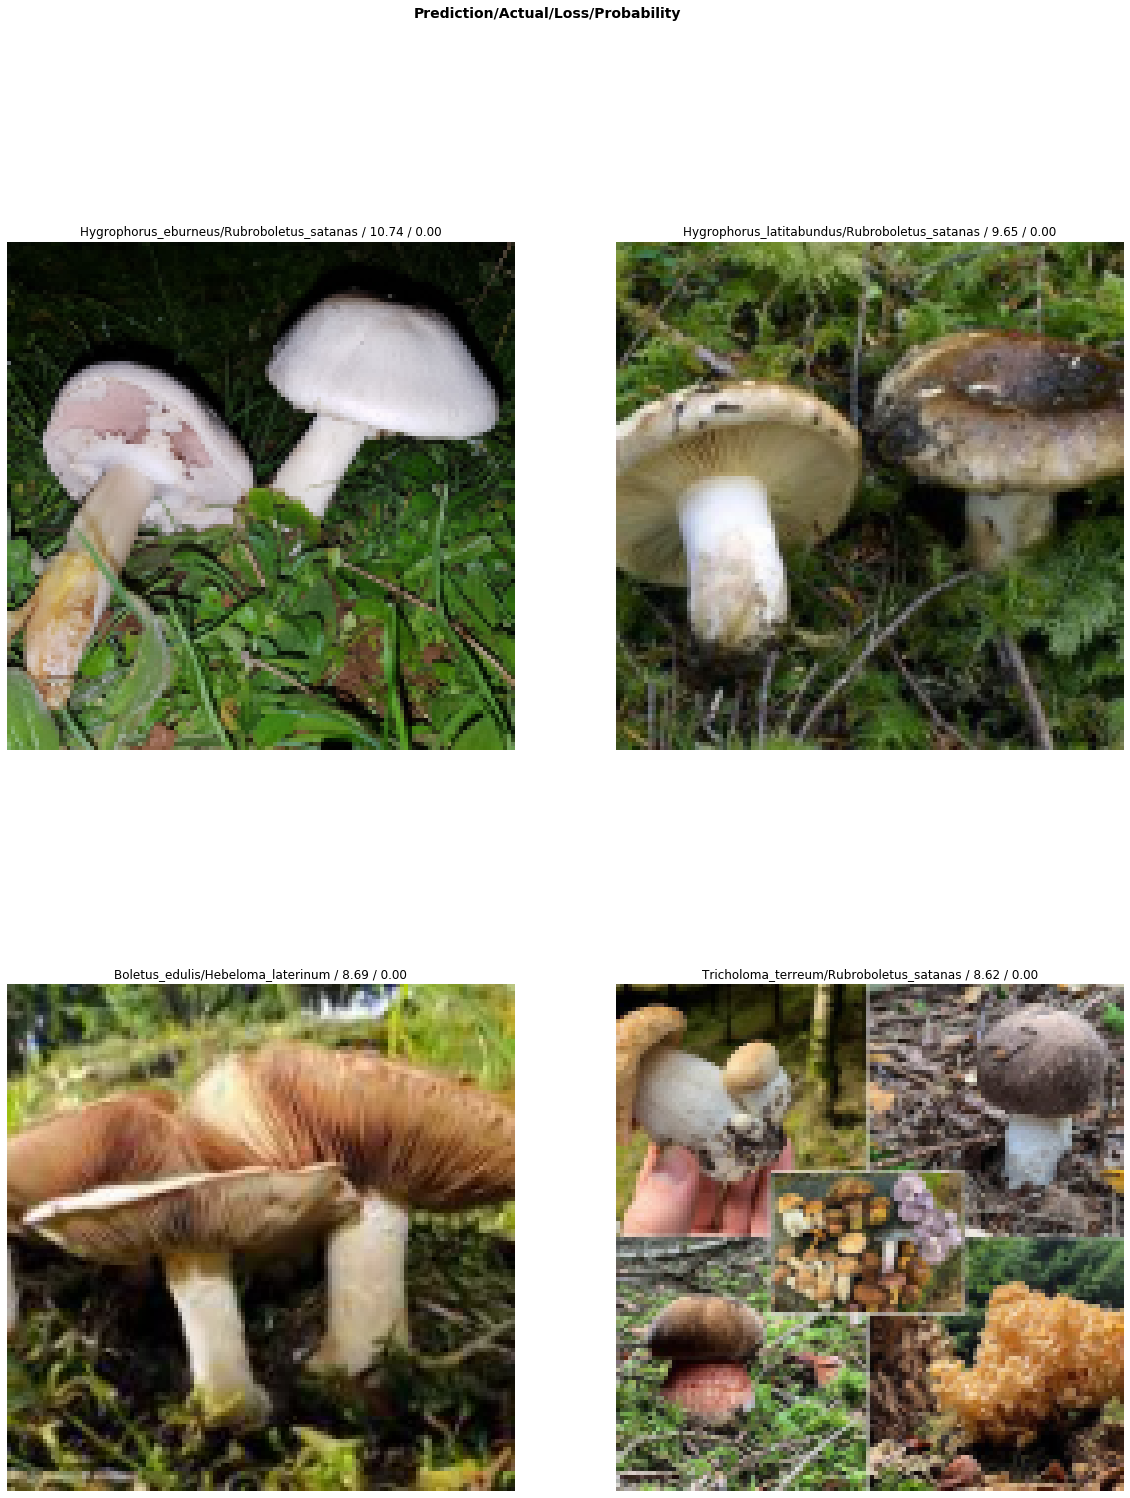

In [52]:
interpret.plot_top_losses(4, figsize=(20, 25))

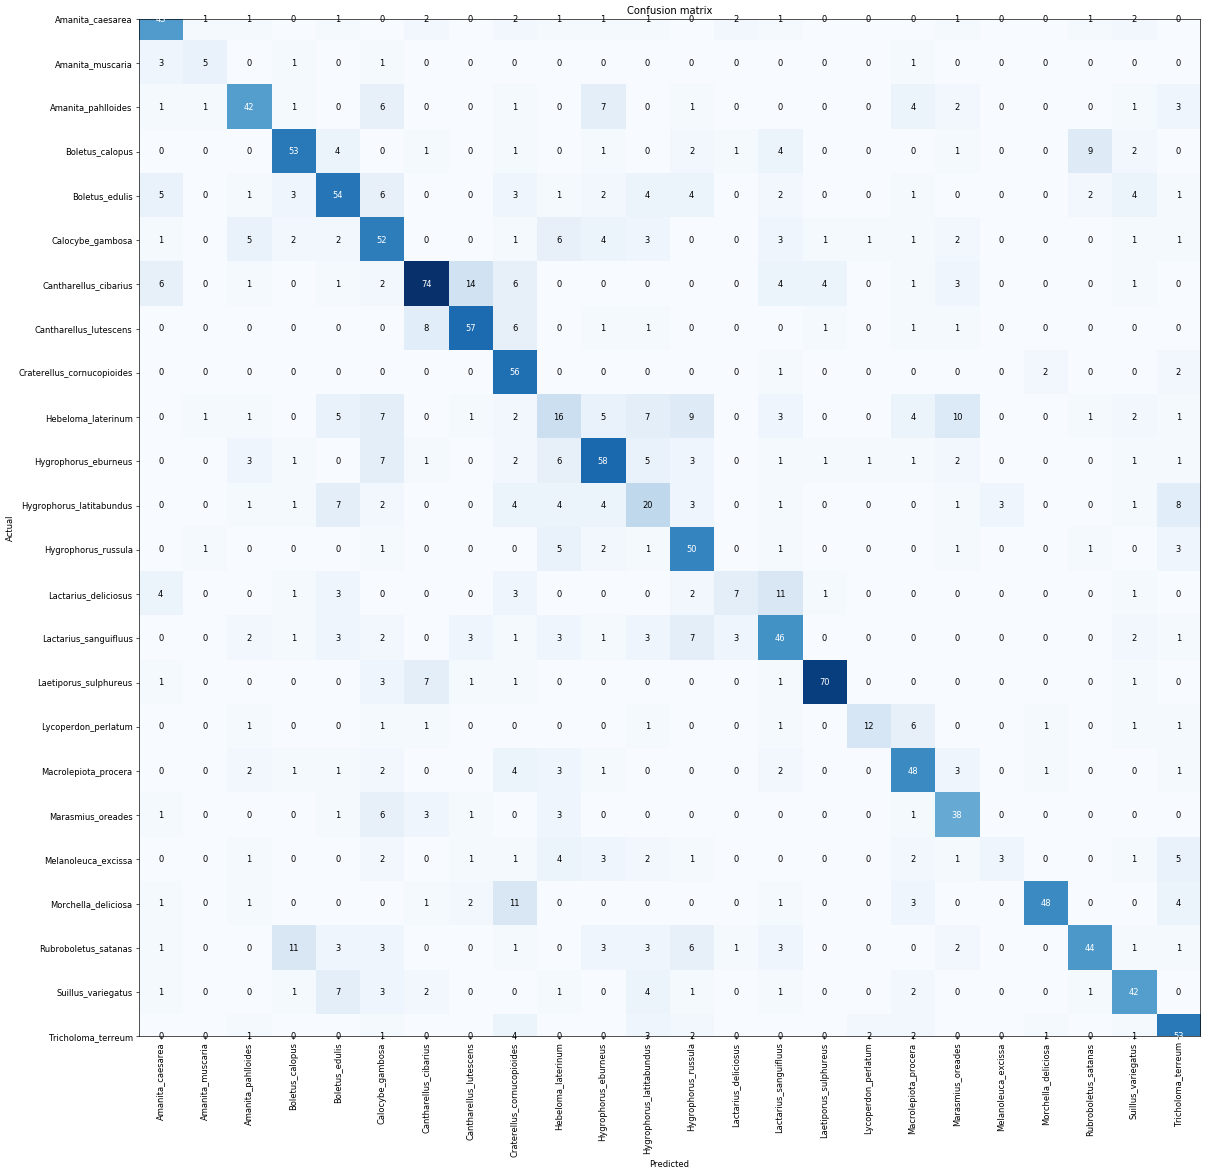

In [53]:
interpret.plot_confusion_matrix(figsize=(20,20), dpi=60)

In [ ]:
model.lr_find()

In [ ]:
model.recorder.plot()

In [ ]:
model.unfreeze()
model.fit_one_cycle(3, max_lr=slice(1e-03, 1e-02))

In [ ]:
model.fit_one_cycle(5, max_lr=slice(1e-03, 1e-02))

In [ ]:
model.save('stage-1-128-rn34_lr_8_cycles')

## Train with image size=256

In [42]:
size=256

In [43]:
img_data = ImageDataBunch.from_folder(
    path=train_folder,
    valid_pct=0.2,  
    ds_tfms=get_transforms(),
    size=size,
    bs=bs,
)

In [ ]:
model.data = img_data

In [ ]:
Veure minut 51 aprox del video Lesson 3, 
Do some data augmentation.
Create new databunch with images of size=256

In [ ]:
model.freeze()
model.lr_find()
model.recorder.plot()

In [ ]:
lr = 1e-3/2
model.fit_one_cycle(2, slice(lr))

In [ ]:
model.fit_one_cycle(3, slice(lr))

In [ ]:
model.save('train_final5_cycles')

In [ ]:
model.load('train_final5_cycles')

In [ ]:
model.export('export_resnet34_model.pkl')

# Deploy Web Page with Elastic Beanstalk

Tutorial Client: https://docs.aws.amazon.com/elasticbeanstalk/latest/dg/eb-cli3.html

Titorial Bundle: https://docs.aws.amazon.com/elasticbeanstalk/latest/dg/applications-sourcebundle.html

# References

* [Fastai multi label](https://gilberttanner.com/blog/fastai-multi-label-image-classification)
* [Google images scrapping](https://medium.com/@intprogrammer/how-to-scrape-google-for-images-to-train-your-machine-learning-classifiers-on-565076972ce)
* [Basic mushroom info](https://bolets.info/)
* [Mushroom names in Latin and additional info](https://ca.wikipedia.org/)
* [Instagram @natros56](https://www.instagram.com/explore/tags/indexboletsnatros56_cat/)




# Not Used